let's move on to **Topic 8: Polynomial Regression**. This technique allows us to use the machinery of linear regression to model non-linear relationships in our data.

---

**1. Why Polynomial Regression? The Limits of Linearity**

  * Standard Linear Regression (Simple or Multiple) assumes that the relationship between the independent features ($X$) and the dependent variable ($y$) is linear. This means it tries to fit a straight line (or a flat hyperplane) to the data.

  * However, in many real-world scenarios, the true relationship is **non-linear** (curved). If we try to fit a linear model to such data, it will result in a poor fit and inaccurate predictions (underfitting).

    *(Conceptual image: A scatter plot of data points following a clear curve, with a straight line from linear regression poorly fitting it.)*

  * **Polynomial Regression** provides a way to extend linear models to capture these non-linear trends by introducing polynomial terms of the features as new features.

---

**2. What is Polynomial Regression?**

  * The core idea is to transform our original features by creating new features that are powers of the original features (e.g., $x^2, x^3$) or interaction terms between features ($x\_1x\_2$).
  * Once these new polynomial features are created, we then fit a standard **Multiple Linear Regression** model to these *engineered* features.
  * So, while the relationship between $y$ and the original feature $x$ might be non-linear, the relationship between $y$ and the new set of features (e.g., $x, x^2$) is modeled linearly. This is why it's still considered a type of linear regression (it's linear in its *coefficients*).

**Example with one original feature $x$:**

  * **Standard Linear Regression (degree 1):**
    $$\hat{y} = b_0 + b_1 x$$
  * **Polynomial Regression (degree 2 - Quadratic):**
    We create a new feature $x^2$. Our model becomes:
    $$\hat{y} = b_0 + b_1 x + b_2 x^2$$
    This is like a multiple linear regression where $x\_1 = x$ and $x\_2 = x^2$.
  * **Polynomial Regression (degree $d$):**
    $$\hat{y} = b_0 + b_1 x + b_2 x^2 + \dots + b_d x^d$$

---

**3. Creating Polynomial Features with Scikit-learn**

Scikit-learn provides the `PolynomialFeatures` transformer in `sklearn.preprocessing` to easily generate these new features.

  * **`PolynomialFeatures(degree=d, include_bias=True/False, interaction_only=False)`:**
      * `degree`: The maximum degree of the polynomial terms to generate.
      * `include_bias`: If `True` (default), includes a column of ones (the bias or intercept term). It's often set to `False` if the subsequent `LinearRegression` model will handle the intercept itself (which it does by default).
      * `interaction_only`: If `True`, only interaction terms are produced (e.g., $x\_1x\_2$), not terms like $x\_1^2$.

**Example:**
If $X = [x\_1, x\_2]$
And `degree=2`, `include_bias=False`:
`PolynomialFeatures` transforms `[x_1, x_2]` into `[x_1, x_2, x_1^2, x_1x_2, x_2^2]`.

---

**4. The Degree of the Polynomial (`d`) - A Crucial Hyperparameter**

  * The `degree` of the polynomial is a hyperparameter that you must choose. It determines the flexibility of the model.
      * `d=1`: Standard linear regression.
      * `d=2`: Quadratic model (can fit a single curve, like a parabola).
      * `d=3`: Cubic model (can fit more complex curves with an inflection point).
      * Higher `d`: Allows the model to fit very intricate, "wiggly" patterns.
  * Choosing the right degree is critical. Visualizing the data can sometimes offer clues, but more systematic approaches like cross-validation are often needed, especially when it's not obvious.

---

**5. Polynomial Regression and Overfitting**

The degree of the polynomial directly impacts the model's complexity and its susceptibility to overfitting:

  * **Low Degree (e.g., `d=1` for curved data):** The model is too simple and cannot capture the underlying trend. This leads to **underfitting** (high bias).
  * **Appropriate Degree:** The model captures the true underlying relationship well without fitting the noise in the training data. This represents a good balance between bias and variance.
  * **High Degree:** The model becomes extremely flexible and can fit the training data (including its noise) almost perfectly. However, it will likely perform very poorly on new, unseen data because it has learned the noise rather than the general trend. This is **overfitting** (high variance).
      * Polynomials of high degree can also exhibit wild oscillations, especially at the boundaries of the data range, making them unreliable for extrapolation.

---


**6. Implementation with Scikit-learn**

Let's create some synthetic non-linear data and see how to apply Polynomial Regression.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [7]:
# --- Generate Synthetic Non-Linear Data ---
np.random.seed(42)
m = 100 # number of samples
X_synth = 6 * np.random.rand(m, 1) - 3 # Feature values between -3 and 3
y_synth = 0.5 * X_synth**2 + X_synth + 2 + np.random.randn(m, 1) # True relationship: y = 0.5x^2 + x + 2 + noise

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_synth, y_synth, test_size=0.2, random_state=42)

In [13]:
# --- Plotting function for visualization ---
def plot_regression_results(X, y, X_test_data, y_test_data, model, title, degree=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='blue', label='Training Data', alpha=0.7)
    plt.scatter(X_test_data, y_test_data, color='green', label='Test Data', alpha=0.7)

    # Generate points for plotting the model's curve
    X_plot = np.linspace(min(X.min(), X_test_data.min()) -1 , max(X.max(), X_test_data.max()) + 1, 100).reshape(-1, 1)

    if degree and hasattr(model, 'steps'): # If it's a pipeline with PolynomialFeatures
        poly_features_transform = model.named_steps['poly_features']
        linear_reg_model = model.named_steps['linear_regression']
        X_plot_poly = poly_features_transform.transform(X_plot)
        y_plot = linear_reg_model.predict(X_plot_poly)
    elif degree: # If it's manual PolynomialFeatures then LinearRegression
         poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)
         X_plot_poly = poly_transformer.fit_transform(X_plot)
         y_plot = model.predict(X_plot_poly)
    else: # Standard Linear Regression
        y_plot = model.predict(X_plot)

    plt.plot(X_plot, y_plot, color='red', linewidth=2, label=f'Model Fit (Degree {degree if degree else 1})')
    plt.xlabel("Feature (X)")
    plt.ylabel("Target (y)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

--- Standard Linear Regression ---
MSE: 2.5342, R2: 0.4297


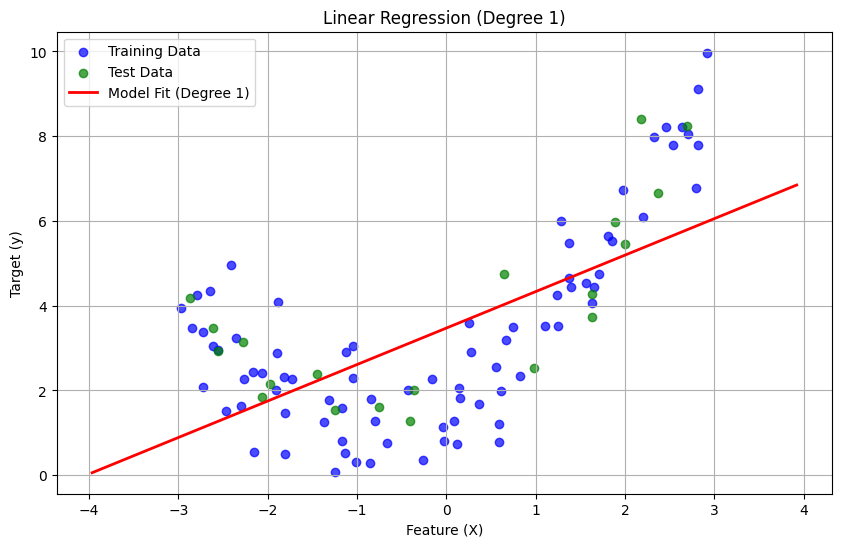

In [10]:
# --- 1. Standard Linear Regression (Underfitting) ---
print("--- Standard Linear Regression ---")
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)
print(f"MSE: {mse_lin:.4f}, R2: {r2_lin:.4f}")
plot_regression_results(X_train, y_train, X_test, y_test, lin_reg, "Linear Regression (Degree 1)", degree=1)


--- Polynomial Regression (Manual Transformation) ---
Original X_train shape: (80, 1)
X_train_poly (degree 2) shape: (80, 2)
Degree 2 - MSE: 0.6358, R2: 0.8569


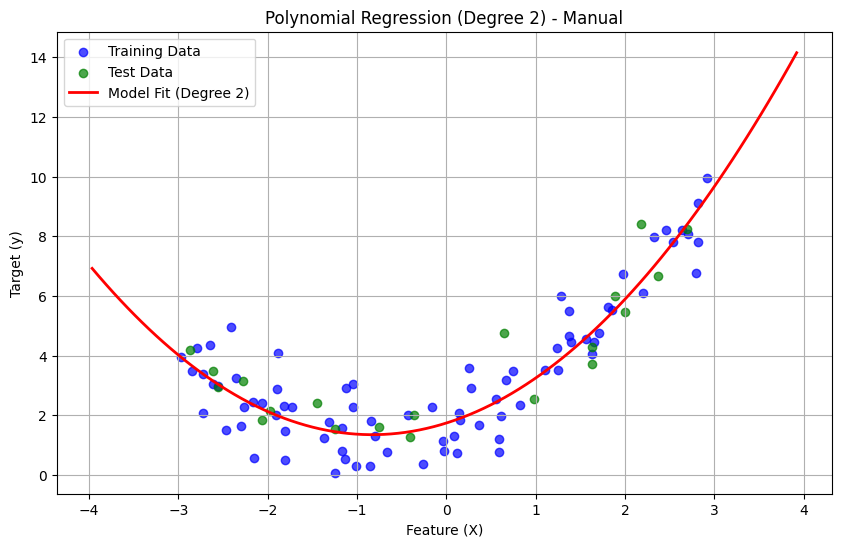

In [9]:
# --- 2. Polynomial Regression (Manual Transformation) ---
print("\n--- Polynomial Regression (Manual Transformation) ---")
degree_poly = 2 # Optimal degree for our synthetic data y = 0.5x^2 + x + 2

poly_features = PolynomialFeatures(degree=degree_poly, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test) # Use transform, not fit_transform, on test data

print(f"Original X_train shape: {X_train.shape}")
print(f"X_train_poly (degree {degree_poly}) shape: {X_train_poly.shape}") # Will have 'degree_poly' features

poly_reg_manual = LinearRegression()
poly_reg_manual.fit(X_train_poly, y_train)

y_pred_poly_manual = poly_reg_manual.predict(X_test_poly)
mse_poly_manual = mean_squared_error(y_test, y_pred_poly_manual)
r2_poly_manual = r2_score(y_test, y_pred_poly_manual)
print(f"Degree {degree_poly} - MSE: {mse_poly_manual:.4f}, R2: {r2_poly_manual:.4f}")
# For plotting with the manual model, we need to pass the degree to the plot function
# The plotting function will handle transforming X_plot based on this degree.
plot_regression_results(X_train, y_train, X_test, y_test, poly_reg_manual, f"Polynomial Regression (Degree {degree_poly}) - Manual", degree=degree_poly)


--- Polynomial Regression using Pipeline ---
Degree 2 (Pipeline) - MSE: 0.6358, R2: 0.8569


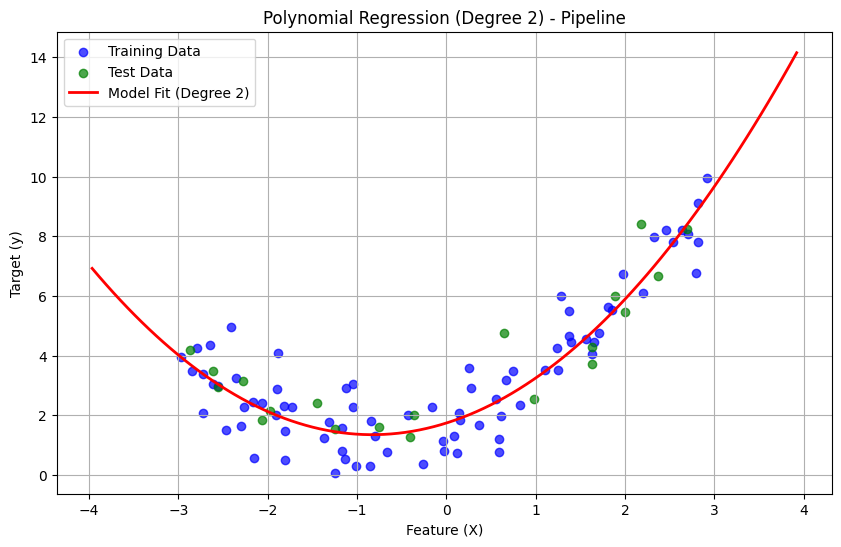

In [14]:
# --- 3. Polynomial Regression using a Pipeline (Recommended) ---
# A Pipeline chains multiple steps: here, PolynomialFeatures and then LinearRegression.
# This is convenient and helps prevent data leakage in more complex scenarios like cross-validation with preprocessing.
print("\n--- Polynomial Regression using Pipeline ---")
poly_pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(degree=degree_poly, include_bias=False)),
    ("linear_regression", LinearRegression())
])
poly_pipeline.fit(X_train, y_train) # Fit the entire pipeline

y_pred_pipeline = poly_pipeline.predict(X_test)
mse_pipeline = mean_squared_error(y_test, y_pred_pipeline)
r2_pipeline = r2_score(y_test, y_pred_pipeline)
print(f"Degree {degree_poly} (Pipeline) - MSE: {mse_pipeline:.4f}, R2: {r2_pipeline:.4f}")
# The plot function is set up to handle pipelines
plot_regression_results(X_train, y_train, X_test, y_test, poly_pipeline, f"Polynomial Regression (Degree {degree_poly}) - Pipeline", degree=degree_poly)



--- Overfitting with High Degree Polynomial ---
Degree 20 (Pipeline):
  Training MSE: 0.6854, Training R2: 0.8736
  Test MSE: 0.8004, Test R2: 0.8199 (Likely very bad R2, high MSE)


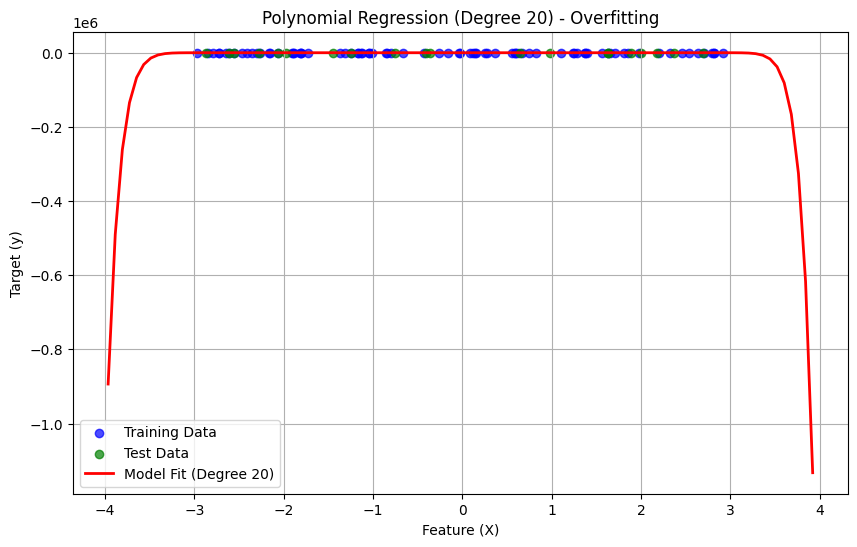

In [15]:
# --- 4. Demonstrating Overfitting with a High Degree Polynomial ---
print("\n--- Overfitting with High Degree Polynomial ---")
degree_overfit = 20
overfit_pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(degree=degree_overfit, include_bias=False)),
    ("linear_regression", LinearRegression())
])
overfit_pipeline.fit(X_train, y_train)

y_pred_overfit_train = overfit_pipeline.predict(X_train) # Check training error
y_pred_overfit_test = overfit_pipeline.predict(X_test)   # Check test error

mse_overfit_train = mean_squared_error(y_train, y_pred_overfit_train)
r2_overfit_train = r2_score(y_train, y_pred_overfit_train)
mse_overfit_test = mean_squared_error(y_test, y_pred_overfit_test)
r2_overfit_test = r2_score(y_test, y_pred_overfit_test)

print(f"Degree {degree_overfit} (Pipeline):")
print(f"  Training MSE: {mse_overfit_train:.4f}, Training R2: {r2_overfit_train:.4f}")
print(f"  Test MSE: {mse_overfit_test:.4f}, Test R2: {r2_overfit_test:.4f} (Likely very bad R2, high MSE)")
plot_regression_results(X_train, y_train, X_test, y_test, overfit_pipeline, f"Polynomial Regression (Degree {degree_overfit}) - Overfitting", degree=degree_overfit)


**Explanation of the Code:**

1.  **Synthetic Data:** We generate data where the true relationship is quadratic ($y = 0.5x^2 + x + 2 + \\text{noise}$).
2.  **Standard Linear Regression:** We first fit a simple linear model to show how it underfits this curved data.
3.  **Polynomial Regression (Manual):**
      * We instantiate `PolynomialFeatures(degree=2)`.
      * We `fit_transform` the training features `X_train` to create `X_train_poly`.
      * Crucially, we only `transform` the test features `X_test` using the *already fitted* `PolynomialFeatures` instance to create `X_test_poly`. This prevents data leakage from the test set into the transformation process.
      * Then, we fit `LinearRegression` on these new polynomial features.
4.  **Polynomial Regression (Pipeline):**
      * Using `sklearn.pipeline.Pipeline` is the recommended way. It bundles the `PolynomialFeatures` transformation and the `LinearRegression` estimation into a single object.
      * When you call `fit()` on the pipeline with `X_train`, it first applies `fit_transform` from `PolynomialFeatures` and then passes the result to `fit` of `LinearRegression`.
      * When you call `predict()` on the pipeline with `X_test`, it first applies `transform` from `PolynomialFeatures` and then passes the result to `predict` of `LinearRegression`. This handles the data flow correctly and is especially useful in cross-validation.
5.  **Overfitting Example:** We demonstrate how a very high degree (e.g., 20) fits the training data very closely (low training MSE, high training R2) but generalizes poorly to the test data (high test MSE, possibly negative R2), showing the characteristic "wiggly" and unreliable curve.

**Feature Scaling with Polynomial Features:**
When you create polynomial features, especially with higher degrees, the range of values for these new features can become very large (e.g., if $x=10$, then $x^5 = 100,000$). This can cause numerical stability issues for the linear regression solver or make regularization (if used) behave unexpectedly.
It's often a good practice to add a `StandardScaler` to your pipeline *after* the `PolynomialFeatures` step:

from sklearn.preprocessing import StandardScaler

- scaled_poly_pipeline = Pipeline([
     - ("poly_features", PolynomialFeatures(degree=degree_poly, include_bias=False)),
     - ("scaler", StandardScaler()), # Scale the polynomial features
     - ("linear_regression", LinearRegression())
 ])
- scaled_poly_pipeline.fit(X_train, y_train)



**7. Pros and Cons of Polynomial Regression**

  * **Pros:**
      * Relatively simple way to model non-linear relationships using the well-understood framework of linear regression.
      * Can capture a wide variety of curved relationships.
      * The resulting model (coefficients of polynomial terms) can still be somewhat interpretable for low degrees.
  * **Cons:**
      * **Choosing the right degree `d` is crucial and can be challenging.** Cross-validation is often needed.
      * **Highly prone to overfitting if the degree `d` is too high.**
      * Polynomials can behave erratically at the boundaries of the data range (i.e., they extrapolate poorly).
      * **Combinatorial explosion of features:** If you have multiple original features ($x\_1, x\_2, \\dots, x\_m$) and a high degree $d$, the number of generated polynomial features (including interaction terms like $x\_1x\_2, x\_1^2x\_2$, etc.) can become extremely large, leading to the "curse of dimensionality," increased computational cost, and higher risk of overfitting. For example, with 10 features and degree 3, you get over 200 features.


**8. When to Use / Alternatives**

  * Polynomial regression is suitable when you observe a relatively simple non-linear trend in your data and have a hypothesis about its polynomial nature, or for exploratory analysis.
  * For more complex non-linear relationships or when you have many features, other models might be more appropriate:
      * **Splines (e.g., in Generalized Additive Models - GAMs):** Fit piecewise polynomials, offering more flexibility and local control.
      * **Tree-based models:** Decision Trees, Random Forests, Gradient Boosting Machines can capture complex non-linearities and interactions automatically.
      * **Support Vector Machines (SVMs) with non-linear kernels (e.g., RBF kernel).**
      * **Neural Networks.**

Polynomial regression is a valuable tool for extending linear models, but it's important to be mindful of its limitations, especially regarding overfitting and the choice of degree.